1. Run "pip install kaggle" 

2. Move "kaggle.json" to following Path /Users/linh/.kaggle

Importing relevent libraries

In [ ]:
pip install nbdime
!nbdime config-git --enable


In [31]:
import pandas as pd 
from cleaning import *  # Import all functions from cleaning
import zipfile
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi  # Import Kaggle Api
import requests
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt

In [32]:
# Initiliaze API
api = KaggleApi()
api.authenticate()
api.model_list_cli()

# Donwload Dataset via API unzipped
api.dataset_download_files(dataset="alexteboul/heart-disease-health-indicators-dataset", unzip=True)

# Saving DataSets into DF
usa_df = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")
india_df = pd.read_csv("./Data/CVD_india_data_raw.csv")

Next Page Token = CfDJ8KWOACvMaNFPiIJ818QpJK13TO5NQte292BHFNkSdmkntdpbkYMWju0ZR9NHpos89Un3njTjF3F4sDyECEaAmdA
    id  ref                                              title                            subtitle                                                                                                                                                                                                                                                       author                                  
------  -----------------------------------------------  -------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  --------------------------------------  
121027  metaresearch/llama-3.2                           Llama 3.2                        The Meta Llama 3.2 collectio

Scrape norm tables from Wikipedia

In [33]:
# blood pressure
url = "https://en.wikipedia.org/wiki/Blood_pressure"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find("table", class_="wikitable")

categories = []
office_data = []
relevant_data = False

for row in table.find_all('tr'):
    header_cells = row.find_all('th')
    if header_cells and "European Society of Cardiology" in header_cells[0].get_text():
        relevant_data = True
        continue
    if header_cells and "European Society of Hypertension" in header_cells[0].get_text():
        relevant_data = False
        break
    if relevant_data:
        data_cells = row.find_all('td')
        if len(data_cells) > 1:  # Ensures we have enough columns
            categories.append(data_cells[0].get_text(strip=True))
            office_data.append(data_cells[1].get_text(strip=True))

bp_df = pd.DataFrame({'Category': categories, 'Office': office_data})
bp_thresh = int(bp_df[bp_df['Category'] == 'Non-elevated']['Office'].values[0].split("<")[1])

In [34]:
# cholesterol
url = "https://en.wikipedia.org/wiki/Cholesterol"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find("table", class_="wikitable")
rows = table.find("tbody").find_all('tr')

chol_data = []
selected_rows = [1, 2, 3, 4]

for i in selected_rows:
    if i == 1:
        cell = rows[i].find('th').get_text(strip=True)
    else:
        cell = rows[i].find('td').get_text(strip=True)
    chol_data.append(cell)

chol_data
chol_thresh = int(chol_data[1].strip("< "))

Creating new binary columns for blood pressure and cholesterol in India data which match the US data

In [35]:
india_df["HighBP"] = india_df["restingBP"].apply(lambda x: 1 if x >= bp_thresh else 0)
print(india_df["HighBP"].unique())

india_df["HighChol"] = india_df["serumcholestrol"].apply(lambda x: 1 if x >= chol_thresh else 0)
print(india_df["HighChol"].unique())

india_df.head()

[1 0]
[0 1]


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target,HighBP,HighChol
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1,1,0
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0,0,1
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0,1,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1,1,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1,1,0


Clean and Shaping Data

In [36]:
# apply functions for cleaning check
check_nan(india_df)
check_unique(india_df)
check_nan(usa_df)
check_unique(usa_df)

no missings in patientid
no missings in age
no missings in gender
no missings in chestpain
no missings in restingBP
no missings in serumcholestrol
no missings in fastingbloodsugar
no missings in restingrelectro
no missings in maxheartrate
no missings in exerciseangia
no missings in oldpeak
no missings in slope
no missings in noofmajorvessels
no missings in target
no missings in HighBP
no missings in HighChol


# of unique vals in patientid: 1000


# of unique vals in age: 61


# of unique vals in gender: 2
unique vals in gender: [0, 1]


# of unique vals in chestpain: 4
unique vals in chestpain: [0, 1, 2, 3]


# of unique vals in restingBP: 95


# of unique vals in serumcholestrol: 344


# of unique vals in fastingbloodsugar: 2
unique vals in fastingbloodsugar: [0, 1]


# of unique vals in restingrelectro: 3
unique vals in restingrelectro: [0, 1, 2]


# of unique vals in maxheartrate: 129


# of unique vals in exerciseangia: 2
unique vals in exerciseangia: [0, 1]


# of unique vals in 

In [37]:
# Synchronize matching columns
usa_df.columns = usa_df.columns.str.lower()
india_df.columns = india_df.columns.str.lower()

In [38]:
# Aligning Dtypes
usa_df = usa_df.apply(lambda x:x.astype(int))
india_df = india_df.apply(lambda x:x.astype(int, errors= "ignore"))

In [39]:
# Checking and konsolodate the columns
# Renaming India columns
india_df = india_df.rename(columns={"target":"cvd"})

# Renaming usa columns
usa_df = usa_df.rename(columns={"sex":"gender"})
usa_df = usa_df.rename(columns={"heartdiseaseorattack":"cvd"})

In [40]:
# assgning gender 
# sacrificing performance for readibility in this case int to object
gender = {
    1:"m",
    0:"f"
}
india_df["gender"] = india_df["gender"].map(gender)  
usa_df["gender"] = usa_df["gender"].map(gender)

In [41]:
# add country column to both dataframes
india_df['country'] = 'india'
usa_df['country'] = 'usa'

In [42]:
# Concantenate the DataFrames
merged = pd.concat([india_df, usa_df], axis=0, ignore_index=True)
# find common cols
common_columns = india_df.columns.intersection(usa_df.columns)
# drop all columns except those with data in both samples: age, gender, heartdiseaseorattack, highbp, highchol
merged = merged[common_columns]

# cetegorize india age
merged.loc[merged['country'] == 'india', 'age'] = pd.cut(merged.loc[merged['country'] == 'india', 'age'],
                                                               bins=range(18, 85, 5),
                                                               labels=range(1, 14),
                                                               right=True).astype(int)

grouped = (merged.groupby("country")["age"].value_counts(normalize=True).sort_index() * 100).round()

# Print the percentage of each age value for India and USA separately
print(grouped)
print(merged.head())

# save
merged.to_csv("./Data/merged_data.csv")

country  age
india    1       8.0
         2       9.0
         3       8.0
         4       8.0
         5       8.0
         6       9.0
         7       8.0
         8       8.0
         9       8.0
         10      7.0
         11      8.0
         12      8.0
         13      3.0
usa      1       2.0
         2       3.0
         3       4.0
         4       5.0
         5       6.0
         6       8.0
         7      10.0
         8      12.0
         9      13.0
         10     13.0
         11      9.0
         12      6.0
         13      7.0
Name: proportion, dtype: float64
   age gender  cvd  highbp  highchol country
0    7      m    1       1         0   india
1    5      m    0       0         1   india
2    7      m    0       1         0   india
3    5      m    1       1         1   india
4    3      m    1       1         0   india


Data Analysis

Analysis on combined data

In [43]:
# H1: The prevalence of high blood pressure is higher in the USA compared to India
# H2: The prevalence of high cholesterol is higher in the USA compared to India
# H3: The prevalence of heart disease is higher in the USA compared to India
grouped = merged.groupby("country")[["highbp", "highchol", "cvd"]].mean() * 100

print("Prevalence by Country:")
print(grouped)
print()

# Logical statements to compare the USA and India for each condition
print("H1: The prevalence of high blood pressure is higher in the US compared to India:", grouped.loc["usa", "highbp"] > grouped.loc["india", "highbp"])
print("H2: The prevalence of high cholesterol is higher in the US compared to India:", grouped.loc["usa", "highchol"] > grouped.loc["india", "highchol"])
print("H3: The prevalence of CVD is higher in the US compared to India:", grouped.loc["usa", "cvd"] > grouped.loc["india", "cvd"])

Prevalence by Country:
           highbp   highchol        cvd
country                                
india    89.40000  82.400000  58.000000
usa      42.90011  42.412094   9.418559

H1: The prevalence of high blood pressure is higher in the US compared to India: False
H2: The prevalence of high cholesterol is higher in the US compared to India: False
H3: The prevalence of CVD is higher in the US compared to India: False


Analysis on US sample

In [44]:
# H4: The prevalence of cvd is higher among smokers than non-smokers
smoker = usa_df[usa_df["smoker"] == 1]
non_smoker = usa_df[usa_df["smoker"] == 0]

# Calculating the percentage of individuals with heart disease in each group
cvd_smoker = (smoker["cvd"].mean()) * 100
cvd_non_smoker = (non_smoker["cvd"].mean()) * 100

print(f"CVD prevalence among smokers: {cvd_smoker:.2f}%")
print(f"CVD prevalence among non-smokers: {cvd_non_smoker:.2f}%")
print("H4: The prevalence of CVD is higher among smokers than non-smokers:" , cvd_smoker > cvd_non_smoker)

CVD prevalence among smokers: 13.17%
CVD prevalence among non-smokers: 6.44%
H4: The prevalence of CVD is higher among smokers than non-smokers: True


In [45]:
# H5: The prevalence of cvd is higher among those with high BP
high_bp = usa_df[usa_df["highbp"] == 1]
no_high_bp = usa_df[usa_df["highbp"] == 0]

# Calculating the percentage of individuals with heart disease in each group
heart_disease_high_bp = (high_bp["cvd"].mean()) * 100
heart_disease_no_high_bp = (no_high_bp["cvd"].mean()) * 100

print(f"Percentage with heart disease among those with high BP: {heart_disease_high_bp:.2f}%")
print(f"Percentage with heart disease among those without high BP: {heart_disease_no_high_bp:.2f}%")
print("H5: The prevalence of CVD is higher among individuals with high BP:" , heart_disease_high_bp > heart_disease_no_high_bp)

Percentage with heart disease among those with high BP: 16.47%
Percentage with heart disease among those without high BP: 4.12%
H5: The prevalence of CVD is higher among individuals with high BP: True


High Chol > in CVD than no CVD

In [46]:
india_df

,patientid,age,gender,chestpain,restingbp,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,cvd,highbp,highchol,country
0,103368,53,m,2,171,0,0,1,147,0,5,3,3,1,1,0,india
1,119250,40,m,0,94,229,0,1,115,0,3,1,1,0,0,1,india
2,119372,49,m,2,133,142,0,0,202,1,5,1,0,0,1,0,india
3,132514,43,m,0,138,295,1,1,153,0,3,2,2,1,1,1,india
4,146211,31,m,1,199,0,0,2,136,0,5,3,2,1,1,0,india
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9949544,48,m,2,139,349,0,2,183,1,5,2,2,1,1,1,india
996,9953423,47,m,3,143,258,1,1,98,1,5,1,0,0,1,1,india
997,9965859,69,m,0,156,434,1,0,196,0,1,3,1,1,1,1,india
998,9988507,45,m,1,186,417,0,1,117,1,5,3,2,1,1,1,india


In [113]:
india_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   patientid          1000 non-null   int32 
 1   age                1000 non-null   int32 
 2   gender             1000 non-null   object
 3   chestpain          1000 non-null   int32 
 4   restingbp          1000 non-null   int32 
 5   serumcholestrol    1000 non-null   int32 
 6   fastingbloodsugar  1000 non-null   int32 
 7   restingrelectro    1000 non-null   int32 
 8   maxheartrate       1000 non-null   int32 
 9   exerciseangia      1000 non-null   int32 
 10  oldpeak            1000 non-null   int32 
 11  slope              1000 non-null   int32 
 12  noofmajorvessels   1000 non-null   int32 
 13  cvd                1000 non-null   int32 
 14  highbp             1000 non-null   int32 
 15  highchol           1000 non-null   int32 
 16  country            1000 non-null   object
d

Zusammenhänge 
RestingBP + Serumcholesterol + Max Heartrate + Age

HighBP + HighCholestoral + CVD # wie in USA

Boxplot 




In [105]:
india_grouped_1 = india_df.groupby("cvd")[["highbp","highchol"]].sum()
india_grouped_1

,highbp,highchol
cvd,,
0,334,340
1,560,484


In [109]:
india_grouped_1= india_grouped.reset_index()

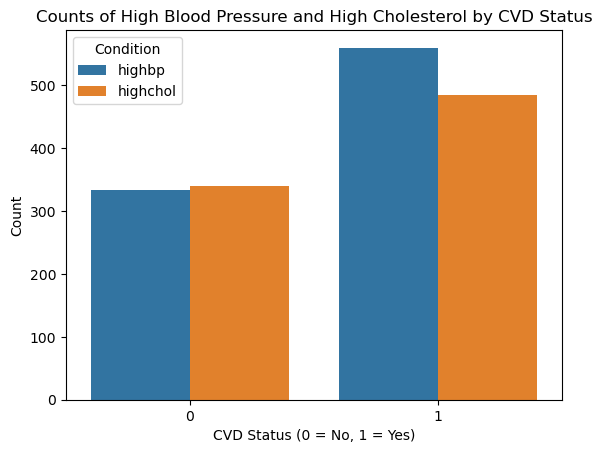

In [111]:
# Step 1: Reshape the data from wide format to long format for Seaborn
india_melted = india_grouped_1.melt(id_vars="cvd", 
                                  value_vars=["highbp", "highchol"], 
                                  var_name="Condition", 
                                  value_name="Count")

# Step 2: Plot using Seaborn
sns.barplot(x="cvd", y="Count", hue="Condition", data=india_melted)
plt.title('Counts of High Blood Pressure and High Cholesterol by CVD Status')
plt.xlabel('CVD Status (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

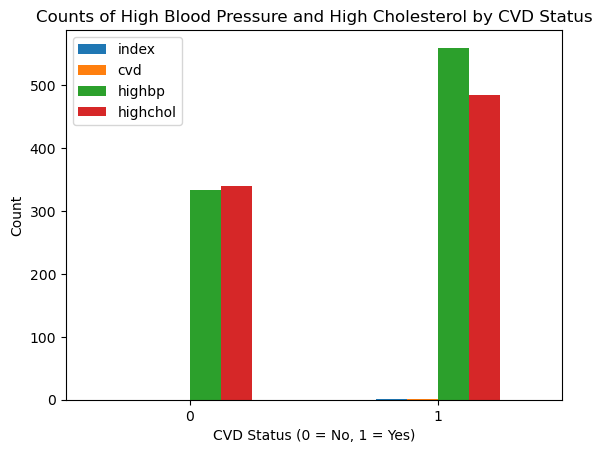

In [110]:
# Assuming india_grouped_1 is the summarized DataFrame showed
# Plotting the data using the existing table format
india_grouped_1.plot(kind="bar")
plt.title('Counts of High Blood Pressure and High Cholesterol by CVD Status')
plt.ylabel('Count')
plt.xlabel('CVD Status (0 = No, 1 = Yes)')
plt.xticks(rotation=0)
plt.show()

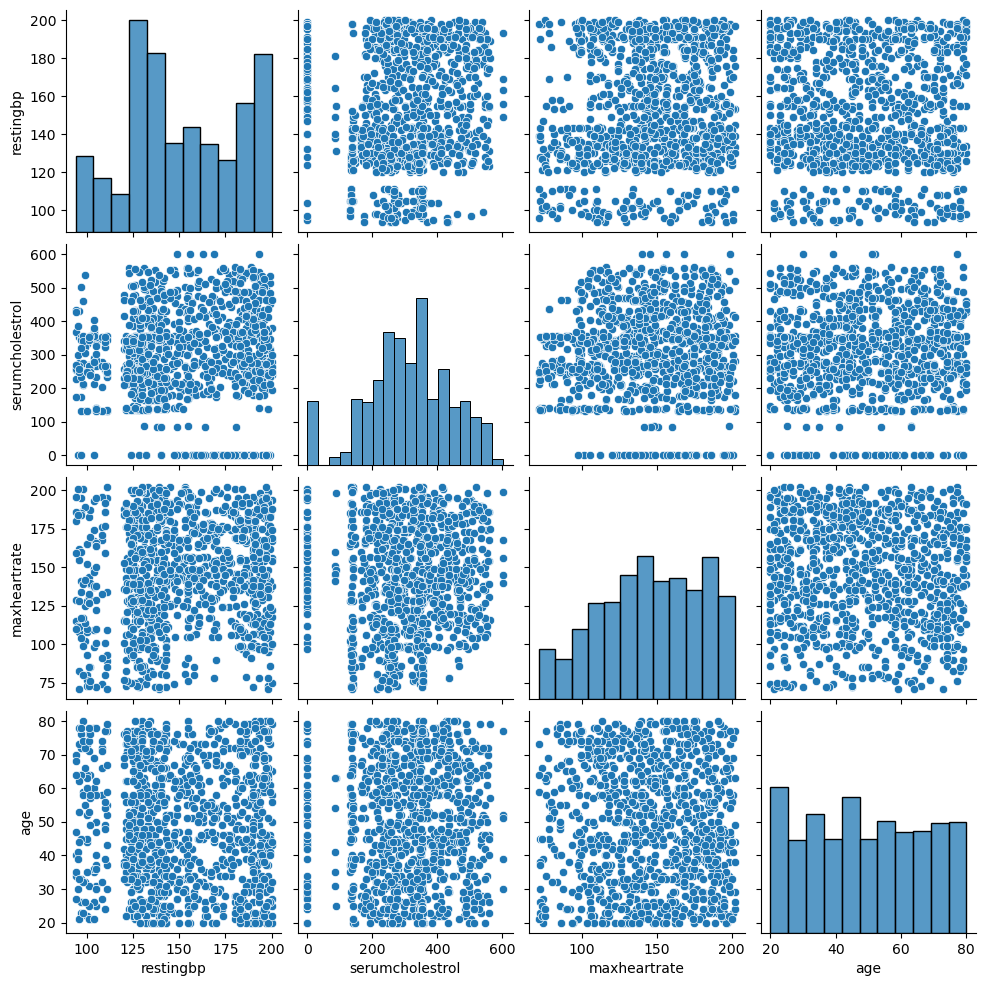

In [116]:
# Scatterplots for each pair of variables
sns.pairplot(india_df[["restingbp", "serumcholestrol","maxheartrate", "age"]])
plt.show()

In [103]:
# H6: The prevalence of cvd is higher among those with high chol

Visualizing the Data

In [49]:
# Defining relevant Plots